In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')

In [2]:
log_filter = np.array([x.endswith("log") for x in os.listdir()])
log_files = np.array(os.listdir())[log_filter]
print(log_files)

['isosinglet_strange_fermionic_multi.isosinglet_Sm1_G1g_P0_simon_single_pivot_n4_m4_d16_c150.log']


isotriplet S=0 P=(0,0,0) A1um P[SS0] 0
0.066268078789725 0.00022088512514174997
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0
0.156382648231 0.000194652711282
isodoublet S=-1 PSQ=1 A2 k[SS1] 0
0.1844608405634 0.00020999956696680003
isodoublet S=-1 PSQ=2 A2 k[SS0] 0
0.2086751871245 0.00026516563696900005
isodoublet S=-1 PSQ=3 A2 k[SS0] 0
0.23100513965379998 0.0002898526184298
isodoublet S=-1 PSQ=4 A2 k[SS1] 0
0.25079156109480005 0.0004106119309806
isodoublet S=0 P=(0,0,0) G1g N[SS0] 0
0.3166662424204 0.002240403397206
isodoublet S=0 PSQ=1 G1 N[SS0] 0
0.33000567193499997 0.0018476216013866668
isodoublet S=0 PSQ=2 G N[SS0] 0
0.34795952332133334 0.0015216428444366666
isodoublet S=0 PSQ=3 G N[SS0] 0
0.35641716715525 0.00250764204185
isotriplet S=-1 P=(0,0,0) G1g S[SS0] 0
0.3835117651012 0.001435487846828
isotriplet S=-1 PSQ=1 G1 S[SS0] 0
0.39268642933250003 0.00170328855874
isotriplet S=-1 PSQ=2 G S[SS0] 0
0.4071974654892 0.0011947475794606
isotriplet S=-1 PSQ=3 G S[SS0] 0
0.417641705915 0.0012550

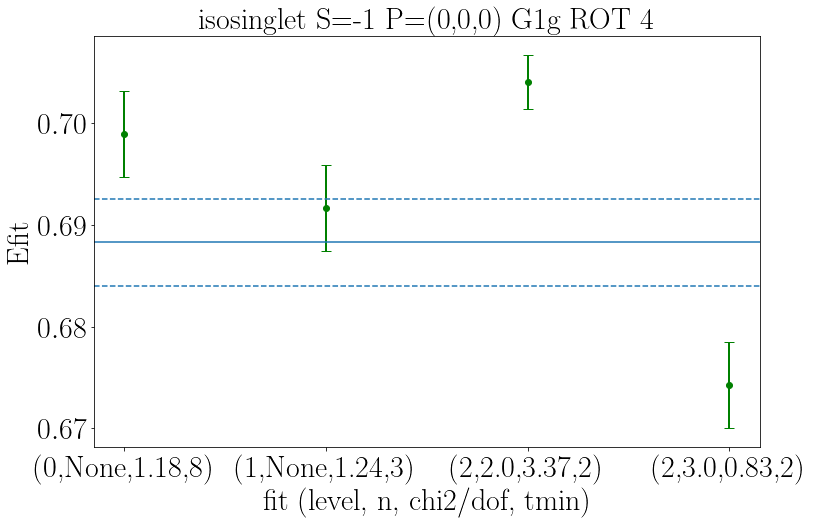

In [29]:
f = plt.figure(facecolor="white")
f.set_figwidth(14)
f.set_figheight(8)
completed_ops = []
ff = open("estimated_averages.csv","w+")
for log_file in log_files:
    data = ET.parse(log_file)
    root = data.getroot()
    for item in root.findall('./Task/DoFit'):
        if item.find("./Type").text =="TemporalCorrelator":
            plt.clf()
            corr = item.find('./TemporalCorrelatorFit/GIOperatorString').text
            if corr not in completed_ops:
                print(corr)
                level = []
                n = []
                fit_values = []
                fit_errs = []
                chi2dof = []
                tmins = []
                for fit_level in item.findall('./IntermediateFitResults'):
                    level.append(int(fit_level.find('./FitLevel').text))
                    if fit_level.findall(f'./N{level[-1]}'):
                        n.append( round(float(fit_level.find(f'./N{level[-1]}').text),1) )
                    else: 
                        n.append(None)
                    fit_values.append( float(fit_level.find('./EnergyFitValue').text) )
                    fit_errs.append( float(fit_level.find('./EnergyErrValue').text) )
                    chi2dof.append( round(float(fit_level.find('./ChiSqDof').text),2) )
                    tmins.append( int(fit_level.find('./Tmin').text) )

                    if fit_values[-1]< 0.0001:
                        level.pop()
                        n.pop()
                        fit_values.pop()
                        fit_errs.pop()
                        chi2dof.pop()
                        tmins.pop()

                x_values = [f"({this_level},{this_n},{this_chi},{thic_tmin})" for this_level, this_n, this_chi, thic_tmin in zip(level,n,chi2dof,tmins)]
                f.set_figwidth(3*len(x_values))
                average_val = 0.0
                num_average = 0
                average_err = 0.0
                for this_chi, fit_value, fit_err in zip(chi2dof,fit_values,fit_errs):
                    if float(this_chi)<=1.45 and float(this_chi)>=0.69:
                        average_val += fit_value
                        num_average += 1
                        average_err += fit_err
                if num_average:
                    average_val /= num_average
                    average_err /= num_average
                    plt.axhline(average_val)
                    plt.axhline(average_val-average_err, ls="--")
                    plt.axhline(average_val+average_err, ls="--")
                    ff.write(f"{corr};{average_val};{average_err}\n")
                    print(average_val,average_err)
                else:
                    best_chisq = chi2dof.index(min(chi2dof))
                    print(fit_values[best_chisq],fit_errs[best_chisq])
                    plt.axhline(fit_values[best_chisq])
                    plt.axhline(fit_values[best_chisq]-fit_errs[best_chisq], ls="--")
                    plt.axhline(fit_values[best_chisq]+fit_errs[best_chisq], ls="--")
                    ff.write(f"{corr};{fit_values[best_chisq]};{fit_errs[best_chisq]}\n")
                    
                plt.errorbar( x_values, fit_values,fit_errs,marker=settings.markers[0],color=settings.colors[0],lw=0.0, elinewidth=2.0, capsize=5.0)
                plt.xlabel( 'fit (level, n, chi2/dof, tmin)')
                plt.ylabel('Efit')
                plt.title(corr)
                plt.tight_layout()
                plt.savefig(corr.replace(" ","_")+"_Efits.png")
                completed_ops.append(corr)
ff.close()

In [23]:
def func(t, E0, E1, A0, A1, A2, A3, A4, A5, n2, n3, n4, n5):
    return A0*np.exp(-E0*t)*(1.0 + A1*np.exp(-E1*E1*t) + A2*np.exp(-n2*E1*E1*t)
                + A3*np.exp(-n3*E1*E1*t) + A4*np.exp(-n4*E1*E1*t) + A5*np.exp(-n5*E1*E1*t))
def fit(t, param_info):
    n = [2.0,1.0,1.0,1.0]
    for i in range(0,4):
        if f'N{i+2}' in param_info.keys():
            n[i] = param_info[f'N{i+2}']
    return func(t, param_info['FitParameter0'], param_info['FitParameter1'], param_info['FitParameter2'], 
               param_info['FitParameter3'], param_info['FitParameter4'], param_info['FitParameter5'], 
               param_info['FitParameter6'], param_info['FitParameter7'],n[0],n[1], n[2],n[3])
    
ni_levels = {
    'isosinglet S=-1 P=(0,0,0) G1g ROT 0': ['isotriplet S=0 PSQ=1 A2m P[SS1] 0','isotriplet S=-1 PSQ=1 G1 S[SS0] 0'],
    'isosinglet S=-1 P=(0,0,0) G1g ROT 1': ['isotriplet S=0 PSQ=1 A2m P[SS1] 0','isotriplet S=-1 PSQ=1 G1 S[SS0] 0'],
    'isosinglet S=-1 P=(0,0,0) G1g ROT 2': ['isodoublet S=-1 PSQ=1 A2 k[SS1] 0', 'isodoublet S=0 PSQ=1 G1 N[SS0] 0'],
    'isosinglet S=-1 P=(0,0,0) G1g ROT 3': ['isotriplet S=0 PSQ=1 A2m P[SS1] 0','isotriplet S=-1 PSQ=1 G1 S[SS0] 0'],
    'isosinglet S=-1 P=(0,0,0) G1g ROT 4': ['isotriplet S=0 PSQ=1 A2m P[SS1] 0','isotriplet S=-1 PSQ=1 G1 S[SS0] 0'],
}

In [5]:
params = {}
completed_ops = []
for log_file in log_files:
    data = ET.parse(log_file)
    root = data.getroot()
    for item in root.findall('./Task/DoFit'):
        if item.find("./Type").text =="TemporalCorrelator":
            corr = item.find('./TemporalCorrelatorFit/GIOperatorString').text
            if corr not in completed_ops:
                plt.clf()
                print(corr)
                params[corr] = {}
                for param in item.findall('./BestFitResult/'):
                    if param.findall('./'):
                        params[corr][param.tag] = float(param.find('MCEstimate/FullEstimate').text)
                    else: 
                        params[corr][param.tag] = float(param.text)

isotriplet S=0 P=(0,0,0) A1um P[SS0] 0
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0
isodoublet S=-1 PSQ=1 A2 k[SS1] 0
isodoublet S=-1 PSQ=2 A2 k[SS0] 0
isodoublet S=-1 PSQ=3 A2 k[SS0] 0
isodoublet S=-1 PSQ=4 A2 k[SS1] 0
isodoublet S=0 P=(0,0,0) G1g N[SS0] 0
isodoublet S=0 PSQ=1 G1 N[SS0] 0
isodoublet S=0 PSQ=2 G N[SS0] 0
isodoublet S=0 PSQ=3 G N[SS0] 0
isotriplet S=-1 P=(0,0,0) G1g S[SS0] 0
isotriplet S=-1 PSQ=1 G1 S[SS0] 0
isotriplet S=-1 PSQ=2 G S[SS0] 0
isotriplet S=-1 PSQ=3 G S[SS0] 0
isotriplet S=0 PSQ=1 A2m P[SS1] 0
isotriplet S=0 PSQ=2 A2m P[SS0] 0
isotriplet S=0 PSQ=3 A2m P[SS0] 0
isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0
isodoublet S=-2 P=(0,0,0) G1g X[SS0] 0
isosinglet S=-1 P=(0,0,0) G1g ROT 0
isosinglet S=-1 P=(0,0,0) G1g ROT 1
isosinglet S=-1 P=(0,0,0) G1g ROT 2
isosinglet S=-1 P=(0,0,0) G1g ROT 3
isosinglet S=-1 P=(0,0,0) G1g ROT 4


<Figure size 432x288 with 0 Axes>

isosinglet S=-1 P=(0,0,0) G1g ROT 0
isosinglet S=-1 P=(0,0,0) G1g ROT 1
isosinglet S=-1 P=(0,0,0) G1g ROT 2
isosinglet S=-1 P=(0,0,0) G1g ROT 3
isosinglet S=-1 P=(0,0,0) G1g ROT 4


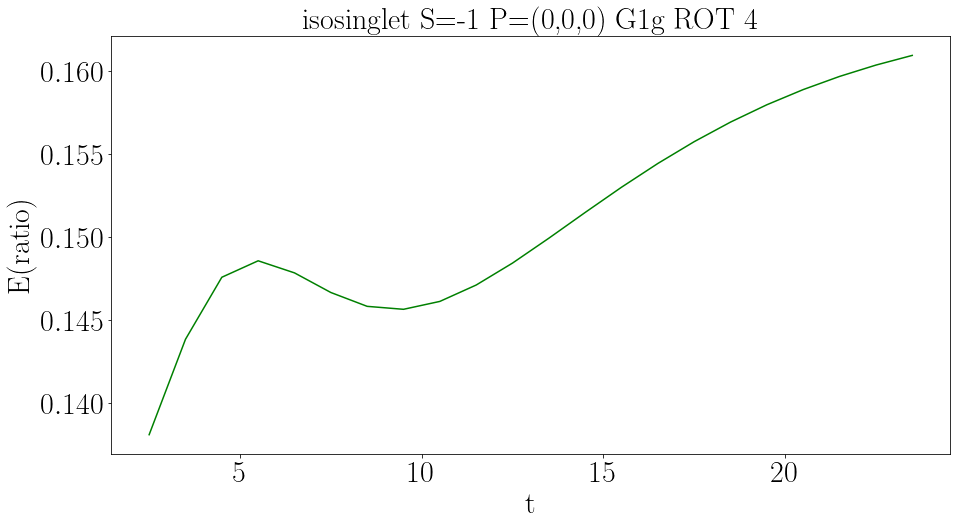

In [6]:
f = plt.figure(facecolor="white")
f.set_figwidth(14)
f.set_figheight(8)
for corr in ni_levels.keys():
    plt.clf()
    t = np.array( range(int(params[corr]['FinalTmin']),25) )
    print(corr)
    vals = fit(t, params[corr])
    
    for ni in ni_levels[corr]:
        ni_vals = fit(t, params[ni])
        vals /= ni_vals
    
    Et, Evals = utils.effenergy(t,vals)
    plt.plot( Et, Evals,color=settings.colors[0])
    plt.xlabel( 't')
    plt.ylabel('E(ratio)')
    plt.title(corr)
    plt.tight_layout()
    plt.savefig(corr.replace(" ","_")+"_Ratio.png")

In [7]:
index = 0
t = np.array( range(int(params[corr]['FinalTmin']),25) )
t[index], fit(t, params[corr])[index]

(2, 5.811309189373561)